# Initiation and Engagement with Treatment Among Oregon Medicaid Beneficiaries with a New Episode of AOD, 2010-2020

## Machine Learning

- Data pre-processing
- Split into test and training sets
- Build Models
- Evaluate
 Finalize

### Declare imports

In [1]:
import pandas as pd
import psycopg2 as pg
from sqlalchemy import create_engine
import sqlalchemy
import io
import csv
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from tableone import TableOne
import matplotlib.ticker as mtick
import numpy as np
import warnings
import sqlite3
from datetime import date
warnings.filterwarnings('ignore')
%load_ext sql

### Print Version and Date

In [2]:
from platform import python_version

print("Python Version:", python_version())

Python Version: 3.9.7


In [3]:
today = date.today()
print("Today's date:", today)

Today's date: 2022-07-29


### Set file directories

In [4]:
user_file = "username.txt"
pw_file = "pw.txt"

### Set up user and password variables

#### User

In [5]:
try:
    uf = open(user_file, "r")
    user = uf.read().strip()
except (Exception, os.error) as error:
    print("Error while opening user file " + user_file + ": ", error)
finally:
    uf.close()

#### Password

In [6]:
try:
    pwf = open(pw_file, "r")
    pw = pwf.read().strip()
except (Exception, os.error) as error:
    print("Error while opening password file " + user_file + ": ", error)
finally:
    pwf.close()

### Database variables

In [7]:
db_server = "albus.ohsu.edu"
db_port = "5432"
db_user = user
db_password = pw
db_name = "hsd"

### Set the connection string for SQLAlchemy

In [8]:
connection_string = "postgresql://" + db_user + ":" + db_password +  "@" + db_server + ":" + db_port + "/" + db_name

### Connect SQLAlchemy

In [12]:
#Connect
%sql "$connection_string"

#### Set up the psycopg2 database connection

In [13]:
con = pg.connect(host = db_server, port = db_port, user= db_user, password = db_password, dbname = db_name)

In [134]:
query = """select * from aod_cohort;"""
group = pd.read_sql(query, con= con)

## Machine Learning

In [137]:
# drop missing
group = group.dropna()

In [138]:
group = pd.get_dummies(group, columns=["race_eth", "age_grp", "year"], prefix=["race", "age", "year"])

In [147]:
#select features
cols = ['t_ident', 'age_13-17', 'age_18-25', 'age_26-34','age_35-44', 'race_Hispanic', 'race_Non-Hispanic non-white', 'race_Unknown', 'urban',  'mh', 'alc', 'opi', 'pain', 'cdps_bin', 'year_2010', 'year_2011', 'year_2012','year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019']
X= group[cols]
y = group.iet_i_num

In [148]:
X.head()

,t_ident,age_13-17,age_18-25,age_26-34,age_35-44,race_Hispanic,race_Non-Hispanic non-white,race_Unknown,urban,mh,...,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019
0,0,0,1,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
6,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [149]:
import sklearn

In [150]:
# Import required libraries for performance metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

# Import required libraries for machine learning classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Instantiate the machine learning classifiers
log_model = LogisticRegression(max_iter=10000)
svc_model = LinearSVC(dual=False)
dtr_model = DecisionTreeClassifier()
rfc_model = RandomForestClassifier()
gnb_model = GaussianNB()

# Define the models evaluation function
def models_evaluation(X, y, folds):
    
    '''
    X : data set features
    y : data set target
    folds : number of cross-validation folds
    
    '''
    
    # Perform cross-validation to each machine learning classifier
    log = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    svc = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    dtr = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    rfc = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    gnb = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)

    # Create a data frame with the models perfoamnce metrics scores
    models_scores_table = pd.DataFrame({'Logistic Regression':[log['test_accuracy'].mean(),
                                                               log['test_precision'].mean(),
                                                               log['test_recall'].mean(),
                                                               log['test_f1_score'].mean()],
                                       
                                      'Support Vector Classifier':[svc['test_accuracy'].mean(),
                                                                   svc['test_precision'].mean(),
                                                                   svc['test_recall'].mean(),
                                                                   svc['test_f1_score'].mean()],
                                       
                                      'Decision Tree':[dtr['test_accuracy'].mean(),
                                                       dtr['test_precision'].mean(),
                                                       dtr['test_recall'].mean(),
                                                       dtr['test_f1_score'].mean()],
                                       
                                      'Random Forest':[rfc['test_accuracy'].mean(),
                                                       rfc['test_precision'].mean(),
                                                       rfc['test_recall'].mean(),
                                                       rfc['test_f1_score'].mean()],
                                       
                                      'Gaussian Naive Bayes':[gnb['test_accuracy'].mean(),
                                                              gnb['test_precision'].mean(),
                                                              gnb['test_recall'].mean(),
                                                              gnb['test_f1_score'].mean()]},
                                      
                                      index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
    
    # Add 'Best Score' column
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)
    
    # Return models performance metrics scores data frame
    return(models_scores_table)

In [151]:
# Run models_evaluation function
models_evaluation(X, y, 10)

,Logistic Regression,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,Best Score
Accuracy,0.661211,0.661221,0.653255,0.651832,0.632185,Support Vector Classifier
Precision,0.496754,0.498142,0.449897,0.447695,0.428758,Support Vector Classifier
Recall,0.030208,0.022573,0.107436,0.120624,0.257002,Gaussian Naive Bayes
F1 Score,0.056871,0.043129,0.173314,0.189948,0.320000,Gaussian Naive Bayes


**What do these mean?** 

- Precision is the accuracy of positive predictions: True Positive / (True Positive + False Positive)
- Recall is the ratio of positives that are actually detected: True Positive / (True Positive + False Negative)
- F1 Score is the harmonic mean of precision and recall

**Takeaway:** 

Overall, these scores are not impressive. We could keep tweaking the model - or go forward with one. Probably the Gaussian Naive Bayes would be preferred. 

**Feature Importance**

I wanted to see if transgender identity came up as an important feature in prediction of treatment. 

In [152]:
#split data
import sklearn
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.25, random_state=42)

In [153]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [154]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [155]:
importances = pd.DataFrame(data={'Attribute': X_train.columns, 'Importance': model.coef_[0]})
importances = importances.sort_values(by='Importance', ascending=False)

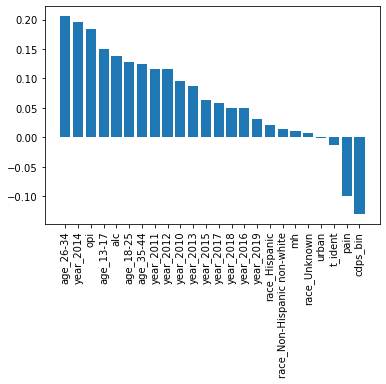

In [156]:
plt.bar(x=importances['Attribute'], height=importances['Importance'])
plt.xticks(rotation='vertical')
plt.show()

In [157]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(LinearSVC(dual=False))
sel.fit(X_train, y_train)

SelectFromModel(estimator=LinearSVC(dual=False))

In [158]:
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

11

In [159]:
print(selected_feat)

Index(['age_13-17', 'age_18-25', 'age_26-34', 'age_35-44', 'alc', 'opi',
       'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014'],
      dtype='object')


In [160]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier())
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [161]:
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['age_26-34', 'race_Hispanic', 'race_Non-Hispanic non-white', 'urban',
       'mh', 'alc', 'opi', 'pain', 'cdps_bin'],
      dtype='object')
